In [1]:
!pip install arch
from arch import arch_model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 17.1 MB/s eta 0:00:00


In [2]:
"""
Hybrid GARCH(1,1) + Conv1d Neural Network Model with Dynamic Volatility Layer

The NN learns a persistence parameter C = α + β and a split factor ρ from historical data.
From (C, ρ) it reconstructs (α, β), which are then passed with ω to a differentiable GARCH
layer to predict the next conditional variance.

This implementation includes:
- Proper train/validation/test split
- Global standardisation of returns before NN and arch_model
- Training on log-variance log(σ²) instead of raw σ²
- Extensive diagnostic visualizations
- Parameter learning tracking over epochs
- Extra plots: α_true vs α_pred on train / val / test
"""

from arch import arch_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List
import torch.nn.functional as F
from torch.utils.data import Dataset

# Syntetics DATA

In [3]:
class GARCHGenerator:
    def __init__(self, omega, alpha, beta, n_samples, seed=42):
        assert omega > 0 and alpha >= 0 and beta >= 0 and alpha + beta < 1
        self.omega, self.alpha, self.beta = float(omega), float(alpha), float(beta)
        self.n_samples = int(n_samples)
        self.seed = int(seed)

    def generate_series(self, burn_in=200):
        torch.manual_seed(self.seed)
        sigma2 = self.omega / (1.0 - self.alpha - self.beta)  # sigma2_0

        returns, variances = [], []

        for _ in range(self.n_samples + burn_in):
            # sigma2_t -> génère r_t
            eps = torch.randn(1).item()
            r_t = float(np.sqrt(sigma2) * eps)

            returns.append(r_t)
            variances.append(float(sigma2))  # variance utilisée pour r_t

            # update -> sigma2_{t+1}
            sigma2 = self.omega + self.alpha * (r_t ** 2) + self.beta * sigma2

        # coupe burn-in sur les deux (même longueur)
        returns = returns[burn_in:]
        variances = variances[burn_in:]

        returns = torch.tensor(returns, dtype=torch.float32)
        variances = torch.tensor(variances, dtype=torch.float32)

        assert len(returns) == self.n_samples
        assert len(variances) == self.n_samples

        return returns, variances




def compute_garch_variance_from_params(returns: np.ndarray, omega: float, alpha: float, beta: float) -> np.ndarray:
    """
    Recompute sigma2[t] from returns and params (aligné avec le dataset).
    sigma2[0] init inconditionnelle, puis:
      sigma2[t] = omega + alpha * returns[t-1]^2 + beta * sigma2[t-1], pour t>=1
    """
    T = len(returns)
    sigma2 = np.zeros(T, dtype=np.float64)

    if init_sigma2 is None:
        denom = max(1e-8, 1.0 - alpha - beta)
        init_sigma2 = omega / denom

    sigma2[0] = float(init_sigma2)

    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t-1] ** 2) + beta * sigma2[t-1]

    return sigma2


# Dataset multi-séries “sliding windows”

In [4]:
class MultiGARCHDataset(Dataset):
    def __init__(self, returns_mat, variances_mat, window_size: int, stride: int = 10):
        assert returns_mat.shape == variances_mat.shape
        self.returns = returns_mat
        self.variances = variances_mat
        self.W = int(window_size)
        self.stride = int(stride)

        self.n_series, self.T = self.returns.shape

        # dernier start autorisé (pour que t+W < T)
        self.max_start = self.T - self.W - 1
        if self.max_start < 0:
            raise ValueError(f"series_len={self.T} trop court pour window_size={self.W} (il faut T >= W+1)")

        # nombre de starts: 0, stride, 2*stride, ... <= max_start
        self.windows_per_series = self.max_start // self.stride + 1
        self.n_samples = self.n_series * self.windows_per_series

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx: int):
        series_idx = idx // self.windows_per_series
        k = idx % self.windows_per_series

        t = k * self.stride
        # sécurité (optionnel)
        # assert t <= self.max_start

        x = self.returns[series_idx, t:t+self.W].unsqueeze(-1)  # [W,1]
        y = self.variances[series_idx, t+self.W]                # scalar
        return x, y


# NN + GARCH

In [5]:
# ============================================================================
# 2. NEURAL NETWORK FOR PARAMETER PREDICTION
# ===========================================================================

class GarchParamNet(nn.Module):
    def __init__(self, hidden=32, kernel=3, conv_layers=5):
        super().__init__()
        layers = []
        in_ch = 1

        for l in range(conv_layers):
            d = 2 ** l
            pad = d * (kernel - 1) // 2  # "same" for odd kernel

            layers += [
                nn.Conv1d(in_ch, hidden, kernel_size=kernel, padding=pad, dilation=d),
                nn.GroupNorm(num_groups=8, num_channels=hidden),
                nn.LeakyReLU(0.2),
            ]
            in_ch = hidden    # nn.BatchNorm1d(hidden)

        self.conv = nn.Sequential(*layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden, hidden // 2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3) ## NOT SURE TO need it
        )

        self.head_omega = nn.Linear(hidden // 2, 1)
        self.head_c     = nn.Linear(hidden // 2, 1)
        self.head_rho   = nn.Linear(hidden // 2, 1)

    def forward(self, x):  # x: [B,T,1]
        x = x.transpose(1, 2)          # [B,1,T]
        h = self.conv(x).mean(dim=2)   # [B,hidden] (global avg pool)  !!! change with attention pooling or GRU if bad result
        h = self.fc(h)                 # [B,hidden//2]

        omega = F.softplus(self.head_omega(h)) + 1e-6
        C     = torch.sigmoid(self.head_c(h)) * 0.99
        rho   = torch.sigmoid(self.head_rho(h))

        alpha = C * rho
        beta  = C * (1 - rho)

        return omega.squeeze(-1), alpha.squeeze(-1), beta.squeeze(-1)


# ============================================================================
# 3. DIFFERENTIABLE GARCH VOLATILITY LAYER
# ============================================================================

class GarchVolLayer(nn.Module):
    def forward(self, r_window, omega, alpha, beta):
        r = r_window.squeeze(-1)  # [B,T]

        # init unconditional (broadcast ok)
        sigma2 = omega / (1 - alpha - beta + 1e-8)

        for t in range(r.size(1)):
            sigma2 = omega + alpha * (r[:, t] ** 2) + beta * sigma2

        # sécurité numérique (optionnel mais utile)
        sigma2 = torch.clamp(sigma2, min=1e-10)
        return sigma2


# ============================================================================
# 4. HYBRID MODEL: NN + GARCH VOLATILITY LAYER
# ============================================================================

class HybridGarch(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.net = GarchParamNet(hidden=hidden)
        self.vol = GarchVolLayer()

    def forward(self, r_window):
        omega, alpha, beta = self.net(r_window)
        sigma2 = self.vol(r_window, omega, alpha, beta)
        return sigma2, omega, alpha, beta


# Trainning

In [6]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.MSELoss()
    eps = 1e-8

    total_loss = 0.0
    total_a = total_b = total_w = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)                    # [B,W,1]
        y = y.to(device).float()            # [B]

        pred_sigma2, omega, alpha, beta = model(x)

        loss = criterion(torch.log(pred_sigma2 + eps), torch.log(y + eps))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_w += omega.detach().mean().item() * bs
        total_a += alpha.detach().mean().item() * bs
        total_b += beta.detach().mean().item() * bs
        n += bs

    return total_loss / n, total_w / n, total_a / n, total_b / n


@torch.no_grad()
def validate_epoch(model, loader, device):
    model.eval()
    criterion = nn.MSELoss()
    eps = 1e-8

    total_loss = 0.0
    total_a = total_b = total_w = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device).float()

        pred_sigma2, omega, alpha, beta = model(x)
        loss = criterion(torch.log(pred_sigma2 + eps), torch.log(y + eps))

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_w += omega.detach().mean().item() * bs
        total_a += alpha.detach().mean().item() * bs
        total_b += beta.detach().mean().item() * bs
        n += bs

    return total_loss / n, total_w / n, total_a / n, total_b / n


def train_hybrid_garch(model, train_loader, val_loader, n_epochs, lr, device, ckpt_path="hybrid_garch_pretrained_synth.pt"):

    optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=1e-4  )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2)

    best_val = float("inf")
    history = {"train_loss": [], "val_loss": []}

    for ep in range(1, n_epochs + 1):
        tr_loss, tr_w, tr_a, tr_b = train_epoch(model, train_loader, optimizer, device)
        va_loss, va_w, va_a, va_b = validate_epoch(model, val_loader, device)
        scheduler.step(va_loss)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), ckpt_path)

        if ep == 1 or ep % 2 == 0:
            print(f"Epoch {ep:02d} | train={tr_loss:.6f} | val={va_loss:.6f} | "
                  f"alpha={va_a:.4f} beta={va_b:.4f} (val)")

    print(f"Best val loss = {best_val:.6f} (log-variance MSE)")
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    return history

In [20]:
def eval_log_mse(model, loader, device):
    model.eval()
    eps = 1e-8
    s, n = 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float()
            sigma2_hat, omega, alpha, beta = model(x)
            loss = ((torch.log(sigma2_hat + eps) - torch.log(y + eps))**2).mean()
            bs = x.size(0)
            s += loss.item() * bs
            n += bs
    return s / max(1, n)

nn_extrap = eval_log_mse(model, ex_loader, device)
print("NN extrapolation log-MSE:", nn_extrap)


NN extrapolation log-MSE: 0.0712248858770666


# Base line

In [7]:
def arch_baseline_log_mse_per_series(returns_mat, vars_mat, window_size, fit_ratio=0.6):
    eps = 1e-8
    n_series, T = returns_mat.shape
    W = window_size

    max_start = T - W - 1
    idxs = np.arange(0, max_start + 1) + W  # indices comparés

    fit_len = int(fit_ratio * T)
    mses = []

    for j in range(n_series):
        r = returns_mat[j].cpu().numpy()
        true_s2 = vars_mat[j].cpu().numpy()

        am = arch_model(r[:fit_len], vol="GARCH", p=1, q=1, mean="Zero", dist="normal", rescale=False)
        res = am.fit(disp="off")

        omega = res.params["omega"]
        alpha = res.params["alpha[1]"]
        beta  = res.params["beta[1]"]

        # sigma2_hat sur la partie fit: filtrée par arch
        sigma2_hat = np.zeros(T, dtype=np.float64)
        sigma2_hat[:fit_len] = (res.conditional_volatility ** 2)

        # continuer après fit_len avec recursion, init = dernier sigma2 filtré
        s2 = sigma2_hat[fit_len - 1]
        for t in range(fit_len, T):
            s2 = omega + alpha * (r[t-1] ** 2) + beta * s2
            sigma2_hat[t] = s2

        mse_log = np.mean((np.log(sigma2_hat[idxs] + eps) - np.log(true_s2[idxs] + eps)) ** 2)
        mses.append(mse_log)

    return float(np.mean(mses))

# TEST ZONE

In [9]:
#def main():
# ---------------- config ----------------
N_SERIES = 2000
N_SAMPLES = 2000
WINDOW_SIZE = 90

TRAIN_SPLIT = 0.6
VAL_SPLIT = 0.2

HIDDEN_DIM = 32
BATCH_SIZE = 64
N_EPOCHS = 10
LR = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------- sample params (original scale) ----------
TRUE_OMEGAS = np.random.uniform(0.001, 0.05, size=N_SERIES)
TRUE_BETAS = np.random.uniform(0.01, 0.85, size=N_SERIES)
# keep alpha + beta < 0.99
TRUE_SUMS = np.random.uniform(TRUE_BETAS + 0.01, 0.99)
TRUE_ALPHAS = TRUE_SUMS - TRUE_BETAS

# --------- generate multi-series ----------
all_returns = []
all_variances = []
for j in range(N_SERIES):
    gen = GARCHGenerator(TRUE_OMEGAS[j], TRUE_ALPHAS[j], TRUE_BETAS[j], n_samples=N_SAMPLES, seed=42+j)
    r, s2 = gen.generate_series()
    all_returns.append(r)
    all_variances.append(s2)


all_returns = torch.stack(all_returns, dim=0)     # [N_SERIES, N_SAMPLES]
all_variances = torch.stack(all_variances, dim=0) # [N_SERIES, N_SAMPLES]


# --------- time split (same series, different time blocks) ----------
idx = np.random.permutation(N_SERIES)
n_tr = int(TRAIN_SPLIT * N_SERIES)
n_va = int(VAL_SPLIT   * N_SERIES)

tr_ids = idx[:n_tr]
va_ids = idx[n_tr:n_tr+n_va]
te_ids = idx[n_tr+n_va:]

train_returns_raw = all_returns[tr_ids]
val_returns_raw   = all_returns[va_ids]
test_returns_raw  = all_returns[te_ids]
train_vars_raw    = all_variances[tr_ids]
val_vars_raw      = all_variances[va_ids]
test_vars_raw     = all_variances[te_ids]

# --------- global standardization ----------
mean_r = train_returns_raw.mean()
std_r  = train_returns_raw.std()

train_returns = (train_returns_raw - mean_r) / (std_r + 1e-8)
val_returns   = (val_returns_raw   - mean_r) / (std_r + 1e-8)
test_returns  = (test_returns_raw  - mean_r) / (std_r + 1e-8)

train_vars = train_vars_raw / ((std_r + 1e-8)**2)
val_vars   = val_vars_raw   / ((std_r + 1e-8)**2)
test_vars  = test_vars_raw  / ((std_r + 1e-8)**2)

# Parameters GARCH Series

TRUE_OMEGAS_SCALED = TRUE_OMEGAS / (float(std_r) ** 2)
TRUE_ALPHAS_SCALED = TRUE_ALPHAS
TRUE_BETAS_SCALED  = TRUE_BETAS

# --------- datasets/loaders ----------
train_ds = MultiGARCHDataset(train_returns, train_vars, WINDOW_SIZE)
val_ds   = MultiGARCHDataset(val_returns,   val_vars,   WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# --------- train NN-GARCH ----------
model = HybridGarch(hidden=HIDDEN_DIM).to(device)
history = train_hybrid_garch(
    model, train_loader, val_loader,
    n_epochs=N_EPOCHS, lr=LR, device=device,
    ckpt_path="hybrid_garch_pretrained_synth.pt"
)

# --------- save full checkpoint (useful for real transfer) ----------
torch.save({
    "model_state": model.state_dict(),
    "window_size": WINDOW_SIZE,
    "hidden_dim": HIDDEN_DIM,
    "n_samples": N_SAMPLES,
    "mean_r": float(mean_r),
    "std_r": float(std_r),
}, "hybrid_garch_pretrained_synth_full.pt")
print("Saved: hybrid_garch_pretrained_synth_full.pt")

# --------- ARCH baseline comparison on validation ----------
try:
    mse_arch_val = arch_baseline_log_mse_per_series(val_returns[:100], val_vars[:100], WINDOW_SIZE, fit_ratio=0.6)
    print(f"ARCH baseline (val) log-MSE: {mse_arch_val:.6f}")

except Exception as e:
    print("ARCH baseline skipped (arch not available or error):", repr(e))


Device: cuda
Epoch 01 | train=0.229331 | val=0.082012 | alpha=0.3138 beta=0.2867 (val)
Epoch 02 | train=0.108283 | val=0.070955 | alpha=0.2953 beta=0.3940 (val)
Epoch 04 | train=0.089812 | val=0.062129 | alpha=0.2932 beta=0.3693 (val)
Epoch 06 | train=0.082436 | val=0.065925 | alpha=0.3196 beta=0.3590 (val)
Epoch 08 | train=0.078106 | val=0.056919 | alpha=0.2995 beta=0.3572 (val)
Epoch 10 | train=0.074806 | val=0.052048 | alpha=0.2924 beta=0.3687 (val)
Best val loss = 0.052048 (log-variance MSE)
Saved: hybrid_garch_pretrained_synth_full.pt
ARCH baseline (val) log-MSE: 0.004840


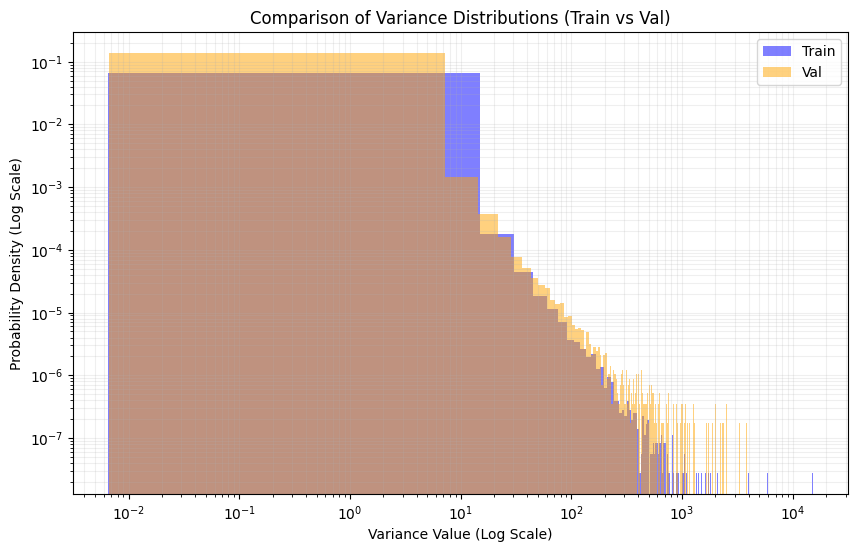

In [10]:
plt.figure(figsize=(10, 6))

# Histogram with 1000 bins and density normalization
plt.hist(train_vars.flatten(), bins=1000, alpha=0.5, label='Train', density=True, color='blue')
plt.hist(val_vars.flatten(), bins=1000, alpha=0.5, label='Val', density=True, color='orange')

# Logarithmic scales for better visualization of financial "fat tails"
plt.yscale('log')
plt.xscale('log')

# English Titles and Labels
plt.title('Comparison of Variance Distributions (Train vs Val)')
plt.xlabel('Variance Value (Log Scale)')
plt.ylabel('Probability Density (Log Scale)')

plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-", alpha=0.2) # Optionnel : ajoute une grille pour mieux lire le log

plt.show()

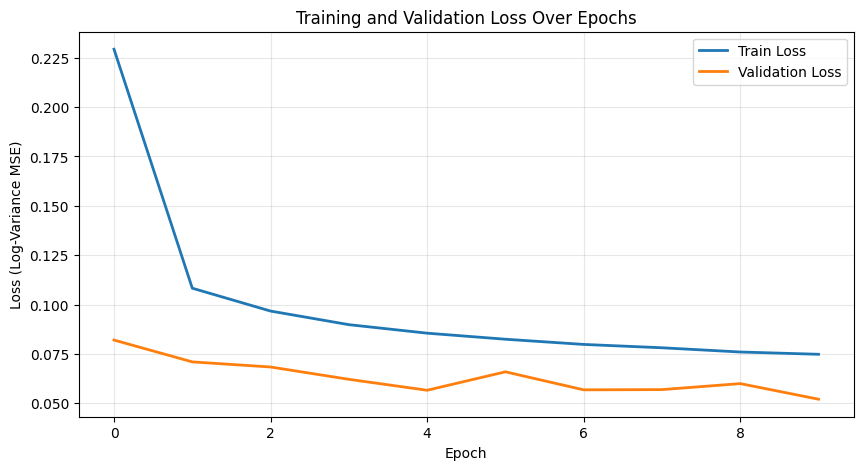

In [11]:
plt.figure(figsize=(10, 5))

# Plotting the loss history
plt.plot(history["train_loss"], label="Train Loss", linewidth=2)
plt.plot(history["val_loss"], label="Validation Loss", linewidth=2)

# English Titles and Labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log-Variance MSE)')

plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

# TEST interpolation

📊 Saved: nn_garch_diagnostics.png


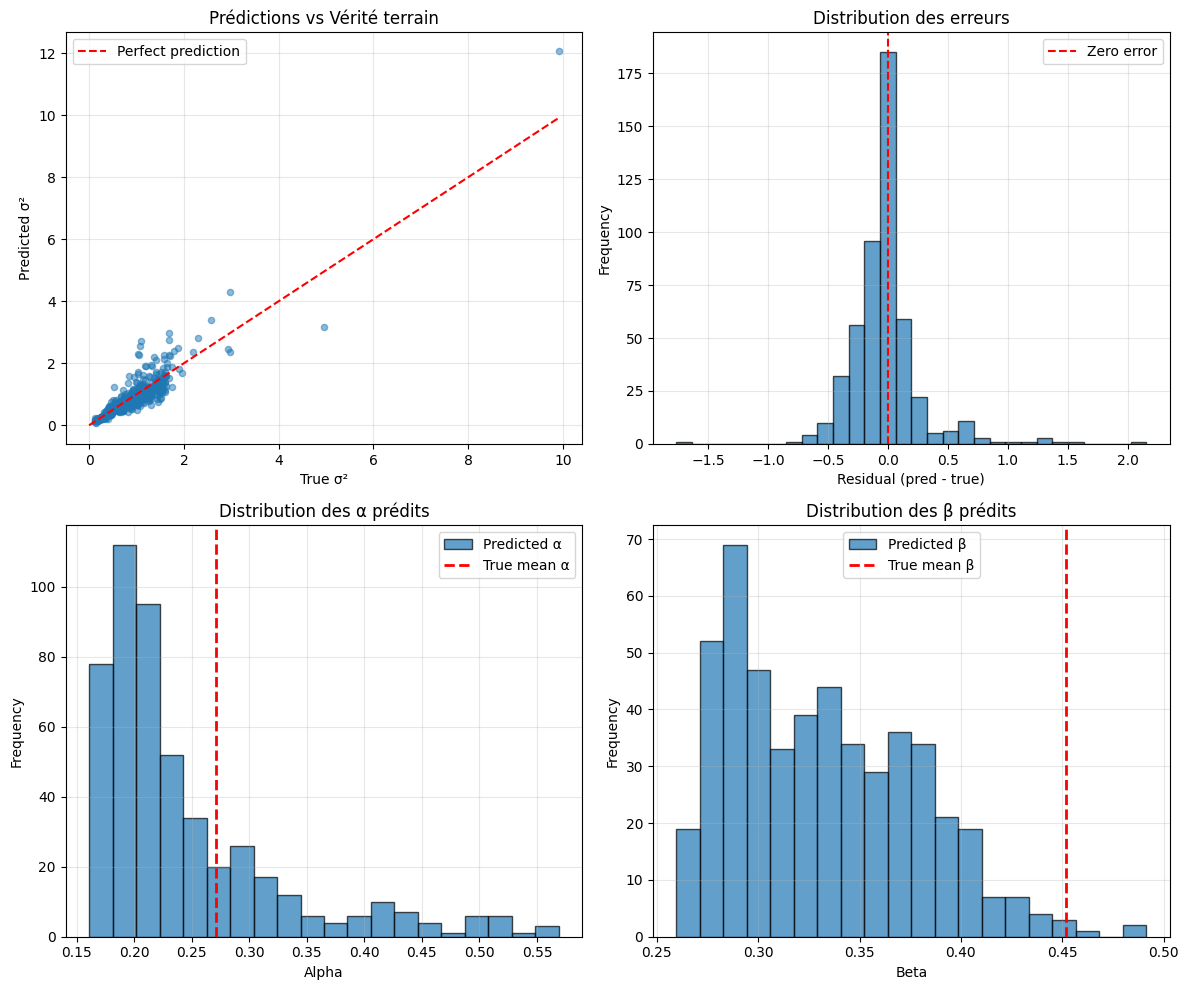


STATISTIQUES DE PRÉDICTION

MSE             : 0.094963
MAE             : 0.189195
R² score        : 0.7882

Mean |residual| : 0.189195
Std residual    : 0.307436

🎯 Paramètres moyens prédits :
   α = 0.2433 ± 0.0824
   β = 0.3319 ± 0.0457
   α+β = 0.5753


In [18]:
"""
Visualisation des prédictions NN-GARCH vs GARCH vrai
À ajouter dans ton notebook après l'entraînement
"""

import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_analysis(model, val_loader, device, n_examples=5):
    """
    Plot quelques exemples de prédictions vs vérité terrain
    """
    model.eval()

    examples = []
    with torch.no_grad():
        for x, y in val_loader:
            if len(examples) >= n_examples:
                break

            x = x.to(device)
            y = y.to(device)

            pred_sigma2, omega, alpha, beta = model(x)

            # Garder quelques samples
            for i in range(min(5, x.size(0))):
                examples.append({
                    'true': y[i].cpu().item(),
                    'pred': pred_sigma2[i].cpu().item(),
                    'omega': omega[i].cpu().item(),
                    'alpha': alpha[i].cpu().item(),
                    'beta': beta[i].cpu().item(),
                })
                if len(examples) >= n_examples:
                    break

    # Plot 1 : Scatter true vs pred
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    true_vals = [ex['true'] for ex in examples]  # Plus d'exemples
    pred_vals = [ex['pred'] for ex in examples]

    axes[0, 0].scatter(true_vals, pred_vals, alpha=0.5, s=20)
    axes[0, 0].plot([0, max(true_vals)], [0, max(true_vals)], 'r--', label='Perfect prediction')
    axes[0, 0].set_xlabel('True σ²')
    axes[0, 0].set_ylabel('Predicted σ²')
    axes[0, 0].set_title('Prédictions vs Vérité terrain')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2 : Résidus
    residuals = np.array(pred_vals) - np.array(true_vals)
    axes[0, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(0, color='r', linestyle='--', label='Zero error')
    axes[0, 1].set_xlabel('Residual (pred - true)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution des erreurs')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3 : Distribution des α prédits
    alphas = [ex['alpha'] for ex in examples]
    axes[1, 0].hist(alphas, bins=20, alpha=0.7, edgecolor='black', label='Predicted α')
    axes[1, 0].axvline(0.271, color='r', linestyle='--', linewidth=2, label='True mean α')
    axes[1, 0].set_xlabel('Alpha')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution des α prédits')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4 : Distribution des β prédits
    betas = [ex['beta'] for ex in examples]
    axes[1, 1].hist(betas, bins=20, alpha=0.7, edgecolor='black', label='Predicted β')
    axes[1, 1].axvline(0.452, color='r', linestyle='--', linewidth=2, label='True mean β')
    axes[1, 1].set_xlabel('Beta')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution des β prédits')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('nn_garch_diagnostics.png', dpi=150, bbox_inches='tight')
    print("📊 Saved: nn_garch_diagnostics.png")
    plt.show()

    # Statistiques
    print("\n" + "=" * 60)
    print("STATISTIQUES DE PRÉDICTION")
    print("=" * 60)
    print(f"\nMSE             : {np.mean((np.array(pred_vals) - np.array(true_vals))**2):.6f}")
    print(f"MAE             : {np.mean(np.abs(residuals)):.6f}")
    print(f"R² score        : {1 - np.var(residuals) / np.var(true_vals):.4f}")
    print(f"\nMean |residual| : {np.mean(np.abs(residuals)):.6f}")
    print(f"Std residual    : {np.std(residuals):.6f}")

    print(f"\n🎯 Paramètres moyens prédits :")
    print(f"   α = {np.mean(alphas):.4f} ± {np.std(alphas):.4f}")
    print(f"   β = {np.mean(betas):.4f} ± {np.std(betas):.4f}")
    print(f"   α+β = {np.mean(alphas) + np.mean(betas):.4f}")

# Utilisation (dans ton notebook après training) :
plot_predictions_analysis(model, val_loader, device, n_examples=500)

EXTRAPOLATION

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("hybrid_garch_pretrained_synth_full.pt", map_location=device)
WINDOW_SIZE = int(ckpt["window_size"])
HIDDEN_DIM  = int(ckpt["hidden_dim"])
mean_r      = float(ckpt["mean_r"])
std_r       = float(ckpt["std_r"])

model = HybridGarch(hidden=HIDDEN_DIM).to(device)
model.load_state_dict(ckpt["model_state"])
model.eval()

print("Loaded | window:", WINDOW_SIZE, "| hidden:", HIDDEN_DIM, "| device:", device)


Loaded | window: 90 | hidden: 32 | device: cuda


In [14]:
def sample_params_by_C(n_series, seed,
                       C_range,
                       rho_range=(0.05, 0.95),
                       vbar_range=(0.5, 5.0)):   # variance inconditionnelle cible
    rng = np.random.default_rng(seed)

    C   = rng.uniform(C_range[0], C_range[1], size=n_series)
    rho = rng.uniform(rho_range[0], rho_range[1], size=n_series)
    vbar = rng.uniform(vbar_range[0], vbar_range[1], size=n_series)

    alpha = C * rho
    beta  = C * (1 - rho)
    omega = vbar * (1 - C)

    return omega, alpha, beta, C


In [15]:
def make_synth_dataset(omegas, alphas, betas, n_samples=2000, burn_in=200, seed0=1000):
    returns_list, vars_list = [], []
    for j in range(len(omegas)):
        gen = GARCHGenerator(omegas[j], alphas[j], betas[j], n_samples=n_samples, seed=seed0 + j)
        r, s2 = gen.generate_series(burn_in=burn_in)
        returns_list.append(r)
        vars_list.append(s2)
    R = torch.stack(returns_list, dim=0)
    S2 = torch.stack(vars_list, dim=0)
    return R, S2

# -------- config ----------
N_TRAIN_SERIES = 2000
N_EXTRAP_SERIES = 400
N_SAMPLES = 2000
BURN_IN = 200
WINDOW_SIZE = 90
BATCH_SIZE = 64

# -------- sample train/extrap params ----------
O_tr, A_tr, B_tr, C_tr = sample_params_by_C(N_TRAIN_SERIES, seed=1, C_range=(0.05, 0.80))
O_ex, A_ex, B_ex, C_ex = sample_params_by_C(N_EXTRAP_SERIES, seed=2, C_range=(0.80, 0.99))

# -------- generate ----------
train_returns_raw, train_vars_raw = make_synth_dataset(O_tr, A_tr, B_tr, n_samples=N_SAMPLES, burn_in=BURN_IN, seed0=5000)
ex_returns_raw, ex_vars_raw       = make_synth_dataset(O_ex, A_ex, B_ex, n_samples=N_SAMPLES, burn_in=BURN_IN, seed0=9000)

# -------- normalize using TRAIN only ----------
mean_r = train_returns_raw.mean()
std_r  = train_returns_raw.std()

train_returns = (train_returns_raw - mean_r) / (std_r + 1e-8)
train_vars    = train_vars_raw / ((std_r + 1e-8)**2)

ex_returns = (ex_returns_raw - mean_r) / (std_r + 1e-8)
ex_vars    = ex_vars_raw / ((std_r + 1e-8)**2)

print("C_train min/mean/max:", C_tr.min(), C_tr.mean(), C_tr.max())
print("C_extrap min/mean/max:", C_ex.min(), C_ex.mean(), C_ex.max())


C_train min/mean/max: 0.05007203041999676 0.42596352744499777 0.7998433577023168
C_extrap min/mean/max: 0.8006054864174423 0.8941755744825446 0.9899920364308284


In [21]:
idx = np.random.permutation(N_TRAIN_SERIES)
n_tr = int(0.8 * N_TRAIN_SERIES)
tr_ids, va_ids = idx[:n_tr], idx[n_tr:]

train_ds = MultiGARCHDataset(train_returns[tr_ids], train_vars[tr_ids], WINDOW_SIZE)
val_ds   = MultiGARCHDataset(train_returns[va_ids], train_vars[va_ids], WINDOW_SIZE)
ex_ds    = MultiGARCHDataset(ex_returns, ex_vars, WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
ex_loader    = DataLoader(ex_ds,    batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


nn_val = eval_log_mse(model, val_loader, device)
nn_ex  = eval_log_mse(model, ex_loader,  device)
print("NN val (C<0.8) log-MSE:", nn_val)
print("NN extrap (C>0.8) log-MSE:", nn_ex)

mse_arch_ex = arch_baseline_log_mse_per_series(ex_returns[:100], ex_vars[:100], WINDOW_SIZE, fit_ratio=0.6)
print("ARCH extrap log-MSE (100 series):", mse_arch_ex)


NN val (C<0.8) log-MSE: 0.06464583882285903
NN extrap (C>0.8) log-MSE: 0.0712248858770666
ARCH extrap log-MSE (100 series): 0.005476782038518392


In [22]:


@torch.no_grad()
def rolling_predict_sigma2(model, r_1d, window_size, device, batch_size=1024):
    """
    r_1d: np.array shape [T] (retours standardisés)
    Returns:
      pred_sigma2: np.array shape [T-window_size] correspondant à t = window_size..T-1
    """
    model.eval()
    r = torch.tensor(r_1d, dtype=torch.float32)

    T = r.shape[0]
    n = T - window_size
    preds = []

    for start in range(0, n, batch_size):
        end = min(n, start + batch_size)
        # windows: [B, W]
        windows = torch.stack([r[i:i+window_size] for i in range(start, end)], dim=0)
        windows = windows.unsqueeze(-1).to(device)   # [B, W, 1]

        sigma2_hat, omega, alpha, beta = model(windows)  # sigma2_hat: [B]
        preds.append(sigma2_hat.detach().cpu().numpy())

    return np.concatenate(preds, axis=0)  # [T-W]


In [23]:
j = 0  # index de série
r_series = ex_returns[j].cpu().numpy()     # [T] retours standardisés
s2_true  = ex_vars[j].cpu().numpy()        # [T] variances standardisées

W = WINDOW_SIZE
s2_pred = rolling_predict_sigma2(model, r_series, W, device)

t = np.arange(W, len(r_series))  # indices alignés (t = W..T-1)
s2_true_aligned = s2_true[W:]    # [T-W]


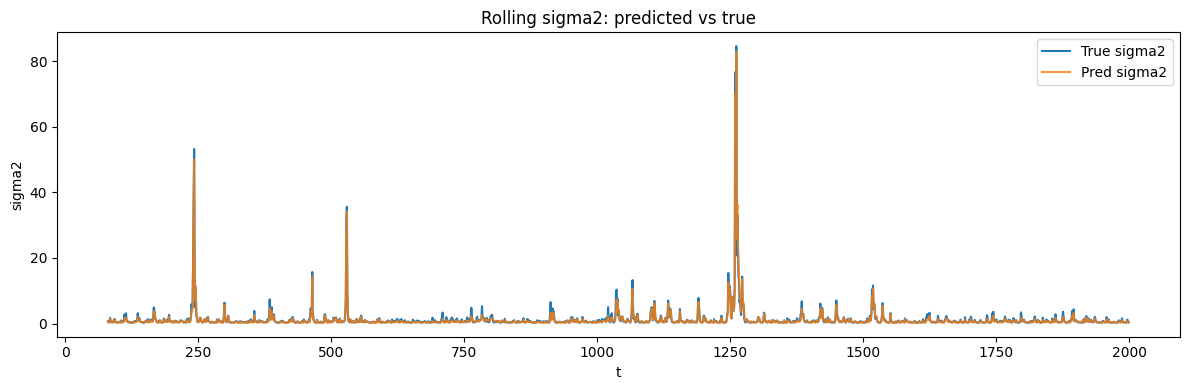

In [24]:
plt.figure(figsize=(12,4))
plt.plot(t, s2_true_aligned, label="True sigma2")
plt.plot(t, s2_pred, label="Pred sigma2", alpha=0.8)
plt.title("Rolling sigma2: predicted vs true")
plt.xlabel("t")
plt.ylabel("sigma2")
plt.legend()
plt.tight_layout()
plt.show()


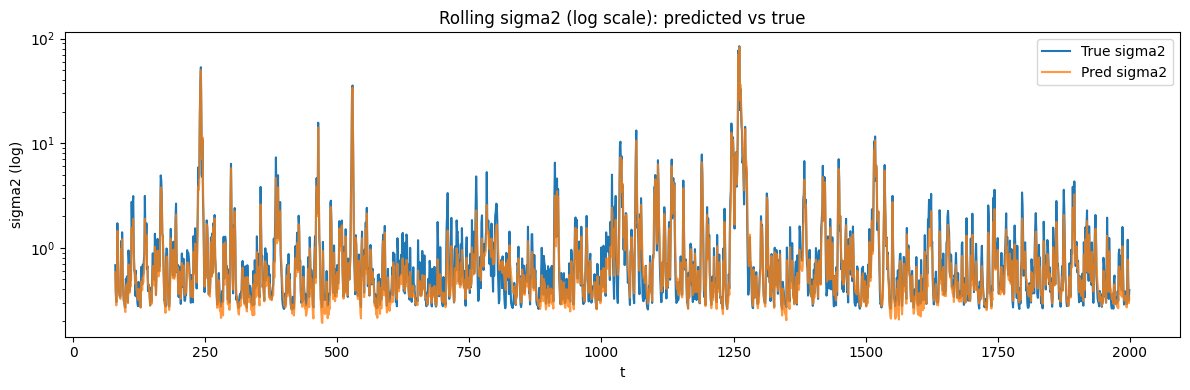

In [25]:
plt.figure(figsize=(12,4))
plt.plot(t, s2_true_aligned, label="True sigma2")
plt.plot(t, s2_pred, label="Pred sigma2", alpha=0.8)
plt.yscale("log")
plt.title("Rolling sigma2 (log scale): predicted vs true")
plt.xlabel("t")
plt.ylabel("sigma2 (log)")
plt.legend()
plt.tight_layout()
plt.show()


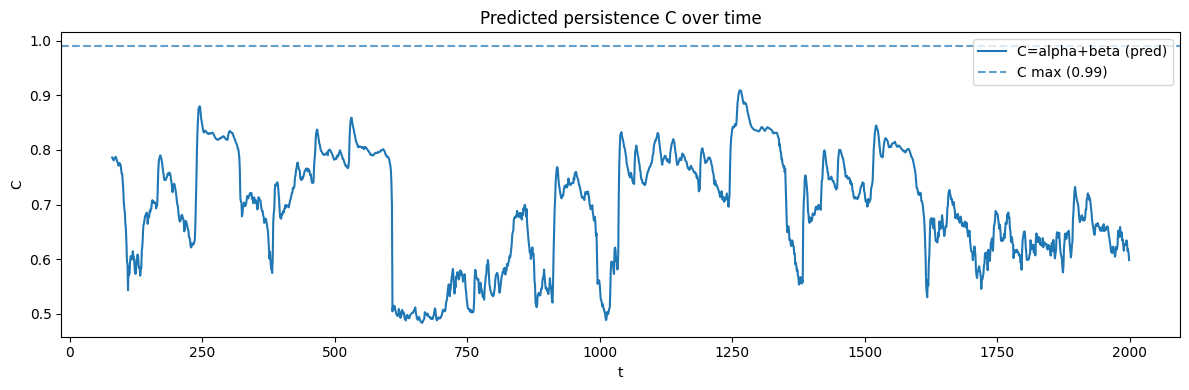

In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def rolling_params(model, r_series, W, device, batch_size=1024):
    model.eval()
    r = torch.tensor(r_series, dtype=torch.float32)
    X = r.unfold(0, W, 1)[:-1].unsqueeze(-1)  # [T-W, W, 1]

    omegas, alphas, betas = [], [], []
    for start in range(0, X.size(0), batch_size):
        xb = X[start:start+batch_size].to(device)
        o, a, b = model.net(xb)   # <-- paramètres prédits
        omegas.append(o.cpu().numpy())
        alphas.append(a.cpu().numpy())
        betas.append(b.cpu().numpy())

    omega = np.concatenate(omegas)
    alpha = np.concatenate(alphas)
    beta  = np.concatenate(betas)
    C = alpha + beta
    return omega, alpha, beta, C

j = 0
r_series = ex_returns[j].cpu().numpy()
W = WINDOW_SIZE
omega_p, alpha_p, beta_p, C_p = rolling_params(model, r_series, W, device)

t = np.arange(W, W+len(C_p))

plt.figure(figsize=(12,4))
plt.plot(t, C_p, label="C=alpha+beta (pred)")
plt.axhline(0.99, linestyle="--", alpha=0.7, label="C max (0.99)")
plt.title("Predicted persistence C over time")
plt.xlabel("t")
plt.ylabel("C")
plt.legend()
plt.tight_layout()
plt.show()


<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\h'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2475634970.py:43: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("True Volatility ($\sigma_{true}$)", fontsize=12)
/tmp/ipython-input-2475634970.py:44: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Predicted Volatility ($\hat{\sigma}$)", fontsize=12)


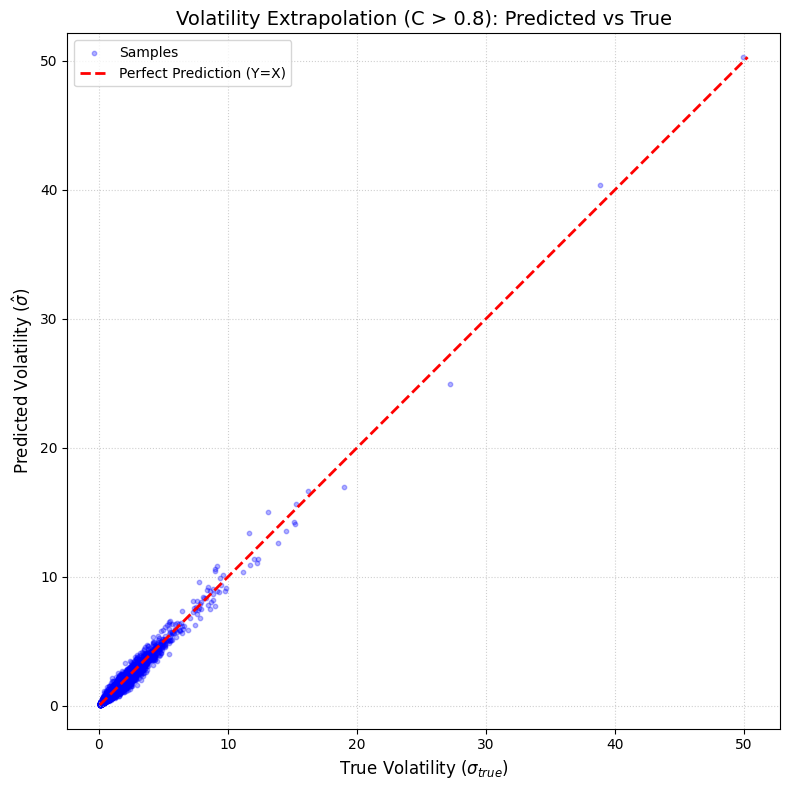

Nombre total de points : 76800
Corrélation : 0.9822


In [39]:
# 1. Collecte de toutes les prédictions et valeurs réelles
model.eval()
all_v_pred = []
all_v_true = []

with torch.no_grad():
    for x_batch, y_batch in ex_loader:
        x_batch = x_batch.to(device)

        # Le modèle renvoie (sigma2, omega, alpha, beta)
        # On extrait sigma2 (le premier élément)
        sigma2_hat, _, _, _ = model(x_batch)

        # Conversion en Volatilité : racine carrée de la variance
        # On utilise .clamp(min=0) pour éviter les erreurs sur les valeurs infimes
        v_pred = torch.sqrt(torch.clamp(sigma2_hat, min=1e-9)).cpu().numpy()
        v_true = torch.sqrt(torch.clamp(y_batch, min=1e-9)).cpu().numpy()

        all_v_pred.extend(v_pred.flatten())
        all_v_true.extend(v_true.flatten())

# Conversion en tableaux numpy pour le plot
all_v_pred = np.array(all_v_pred)
all_v_true = np.array(all_v_true)

# 2. Création du graphique Scatter Plot
plt.figure(figsize=(8, 8))

# Scatter plot avec transparence (alpha) pour voir la densité des points
plt.scatter(all_v_true, all_v_pred, color='blue', alpha=0.3, s=10, label='Samples')

# Ajout de la ligne d'identité (Y=X) pour visualiser la perfection
min_val = min(all_v_true.min(), all_v_pred.min())
max_val = max(all_v_true.max(), all_v_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction (Y=X)')

# Configuration des axes
plt.title("Volatility Extrapolation (C > 0.8): Predicted vs True", fontsize=14)
plt.xlabel("True Volatility ($\sigma_{true}$)", fontsize=12)
plt.ylabel("Predicted Volatility ($\hat{\sigma}$)", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# On force les axes à être à la même échelle pour que la ligne à 45° soit correcte
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print des statistiques pour vérification
print(f"Nombre total de points : {len(all_v_true)}")
print(f"Corrélation : {np.corrcoef(all_v_true, all_v_pred)[0,1]:.4f}")

Extrapolation FULL


In [ ]:
def make_synth_dataset(omegas, alphas, betas, n_samples=2000, burn_in=200, seed0=1000):
    returns_list, vars_list = [], []
    for j in range(len(omegas)):
        gen = GARCHGenerator(omegas[j], alphas[j], betas[j], n_samples=n_samples, seed=seed0 + j)
        r, s2 = gen.generate_series(burn_in=burn_in)
        returns_list.append(r)
        vars_list.append(s2)
    R = torch.stack(returns_list, dim=0)
    S2 = torch.stack(vars_list, dim=0)
    return R, S2

# -------- config ----------
N_TRAIN_SERIES = 2000
N_EXTRAP_SERIES = 400
N_SAMPLES = 2000
BURN_IN = 200
WINDOW_SIZE = 90
BATCH_SIZE = 64

# -------- sample train/extrap params ----------
O_tr, A_tr, B_tr, C_tr = sample_params_by_C(N_TRAIN_SERIES, seed=1, C_range=(0.05, 0.80))
O_ex, A_ex, B_ex, C_ex = sample_params_by_C(N_EXTRAP_SERIES, seed=2, C_range=(0.80, 0.99))

# -------- generate ----------
train_returns_raw, train_vars_raw = make_synth_dataset(O_tr, A_tr, B_tr, n_samples=N_SAMPLES, burn_in=BURN_IN, seed0=5000)
ex_returns_raw, ex_vars_raw       = make_synth_dataset(O_ex, A_ex, B_ex, n_samples=N_SAMPLES, burn_in=BURN_IN, seed0=9000)

# -------- normalize using TRAIN only ----------
mean_r = train_returns_raw.mean()
std_r  = train_returns_raw.std()

train_returns = (train_returns_raw - mean_r) / (std_r + 1e-8)
train_vars    = train_vars_raw / ((std_r + 1e-8)**2)

ex_returns = (ex_returns_raw - mean_r) / (std_r + 1e-8)
ex_vars    = ex_vars_raw / ((std_r + 1e-8)**2)

print("C_train min/mean/max:", C_tr.min(), C_tr.mean(), C_tr.max())
print("C_extrap min/mean/max:", C_ex.min(), C_ex.mean(), C_ex.max())


In [ ]:
idx = np.random.permutation(N_TRAIN_SERIES)
n_tr = int(0.8 * N_TRAIN_SERIES)
tr_ids, va_ids = idx[:n_tr], idx[n_tr:]

train_ds = MultiGARCHDataset(train_returns[tr_ids], train_vars[tr_ids], WINDOW_SIZE)
val_ds   = MultiGARCHDataset(train_returns[va_ids], train_vars[va_ids], WINDOW_SIZE)
ex_ds    = MultiGARCHDataset(ex_returns, ex_vars, WINDOW_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
ex_loader    = DataLoader(ex_ds,    batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


nn_val = eval_log_mse(model, val_loader, device)
nn_ex  = eval_log_mse(model, ex_loader,  device)
print("NN val (C<0.8) log-MSE:", nn_val)
print("NN extrap (C>0.8) log-MSE:", nn_ex)

mse_arch_ex = arch_baseline_log_mse_per_series(ex_returns[:100], ex_vars[:100], WINDOW_SIZE, fit_ratio=0.6)
print("ARCH extrap log-MSE (100 series):", mse_arch_ex)


In [41]:
# --- NEW: train a fresh model on C<0.8 only ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_DIM = 32          # choisis ce que tu veux
N_EPOCHS  = 10
LR        = 1e-4

model_ood = HybridGarch(hidden=HIDDEN_DIM).to(device)

history_ood = train_hybrid_garch(
    model_ood, train_loader, val_loader,
    n_epochs=N_EPOCHS, lr=LR, device=device,
    ckpt_path="hybrid_garch_pretrained_C_lt_08.pt"
)

nn_val = eval_log_mse(model_ood, val_loader, device)
nn_ex  = eval_log_mse(model_ood, ex_loader,  device)

print("NN val (C<0.8) log-MSE:", nn_val)
print("NN extrap (C>0.8) log-MSE:", nn_ex)


Epoch 01 | train=0.080784 | val=0.048791 | alpha=0.2303 beta=0.2592 (val)
Epoch 02 | train=0.055794 | val=0.044699 | alpha=0.2067 beta=0.2516 (val)
Epoch 04 | train=0.050280 | val=0.040341 | alpha=0.2076 beta=0.2375 (val)
Epoch 06 | train=0.048700 | val=0.039619 | alpha=0.2224 beta=0.2309 (val)
Epoch 08 | train=0.047739 | val=0.040007 | alpha=0.2125 beta=0.2277 (val)
Epoch 10 | train=0.046922 | val=0.039323 | alpha=0.2176 beta=0.2261 (val)
Best val loss = 0.039059 (log-variance MSE)
NN val (C<0.8) log-MSE: 0.03905898047417092
NN extrap (C>0.8) log-MSE: 0.14923962242590885


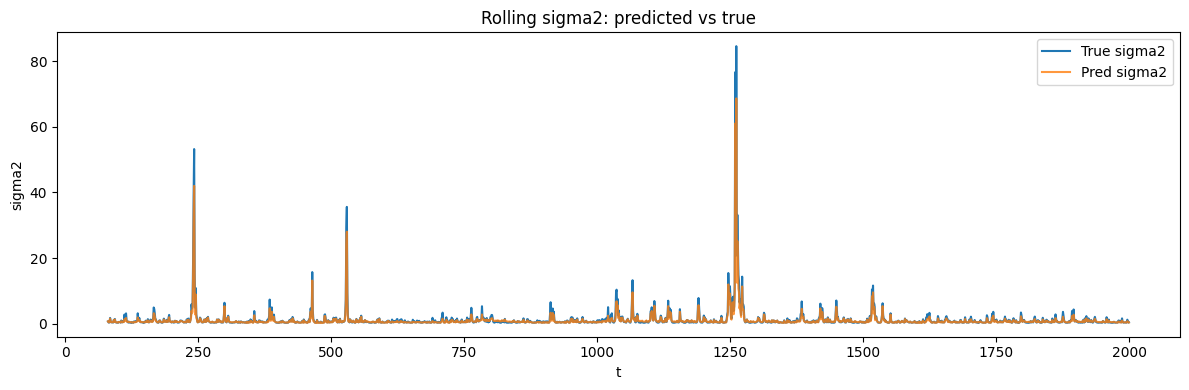

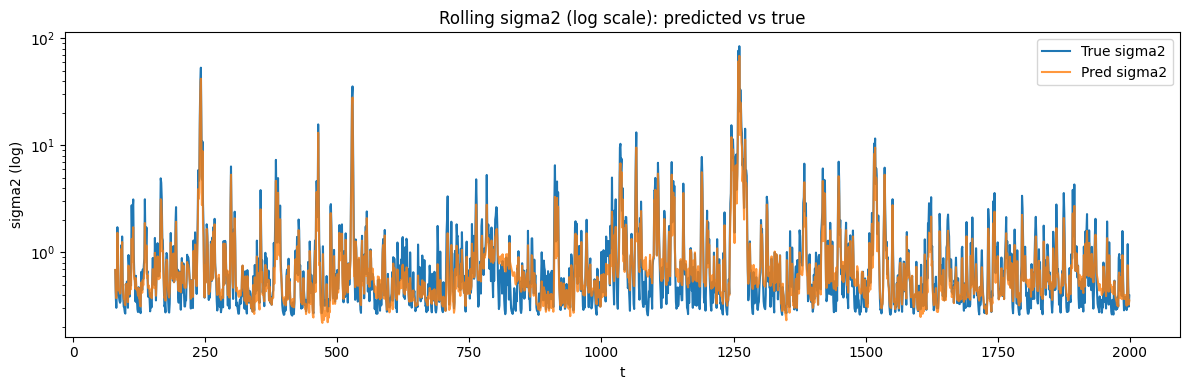

In [42]:
j = 0  # index de série extrap
r_series = ex_returns[j].cpu().numpy()  # [T]
s2_true  = ex_vars[j].cpu().numpy()     # [T]

W = WINDOW_SIZE
s2_pred = rolling_predict_sigma2(model_ood, r_series, W, device)

t = np.arange(W, len(r_series))     # t = W..T-1
s2_true_aligned = s2_true[W:]       # [T-W]

plt.figure(figsize=(12,4))
plt.plot(t, s2_true_aligned, label="True sigma2")
plt.plot(t, s2_pred, label="Pred sigma2", alpha=0.8)
plt.title("Rolling sigma2: predicted vs true")
plt.xlabel("t")
plt.ylabel("sigma2")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, s2_true_aligned, label="True sigma2")
plt.plot(t, s2_pred, label="Pred sigma2", alpha=0.8)
plt.yscale("log")
plt.title("Rolling sigma2 (log scale): predicted vs true")
plt.xlabel("t")
plt.ylabel("sigma2 (log)")
plt.legend()
plt.tight_layout()
plt.show()


Nb points: 76800


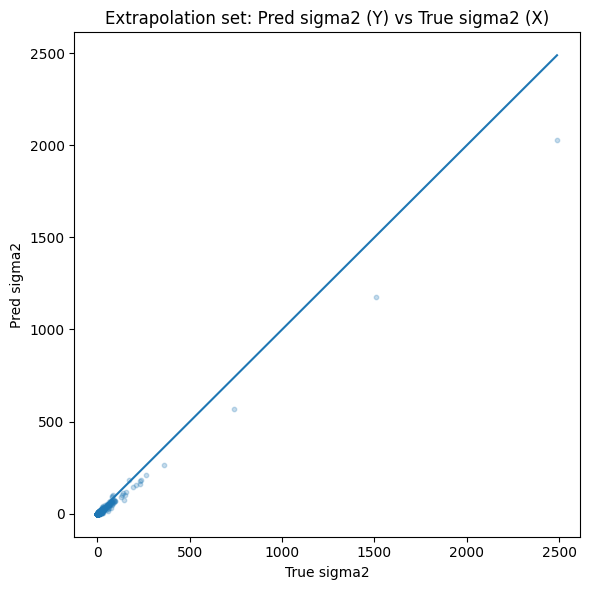

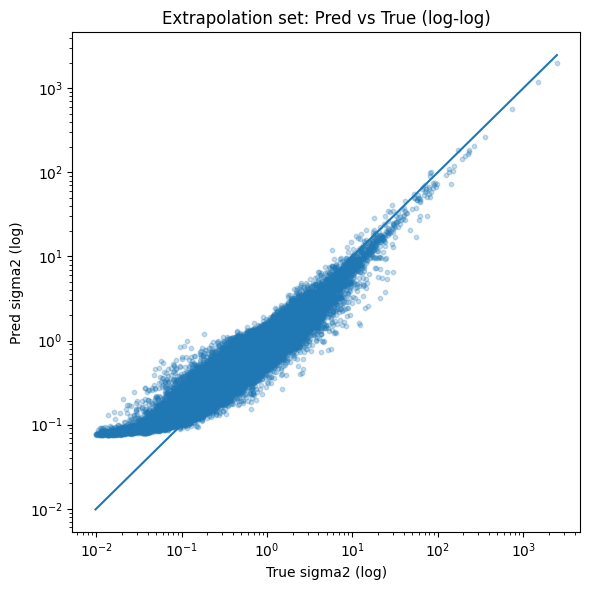

log-MSE: 0.14923966
corr(log true, log pred): 0.9528238694304739


In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def collect_true_pred_sigma2(model, loader, device, max_batches=None, eps=1e-12):
    model.eval()
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for b, batch in enumerate(loader):
            if max_batches is not None and b >= max_batches:
                break

            # batch = (x,y) ou (x,y,idx)
            xb = batch[0].to(device)
            yb = batch[1].to(device)

            out = model(xb)

            # --- IMPORTANT: gérer sortie tuple/list ---
            if isinstance(out, (tuple, list)):
                pred = out[0]
            else:
                pred = out

            # pred et yb doivent être des tensors (B,) ou (B,1)
            pred = torch.clamp(pred, min=eps)
            yb   = torch.clamp(yb,   min=eps)

            y_true_list.append(yb.detach().cpu().numpy().reshape(-1))
            y_pred_list.append(pred.detach().cpu().numpy().reshape(-1))

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    return y_true, y_pred


# --- Collect sur le test extrapolation ---
y_true_ex, y_pred_ex = collect_true_pred_sigma2(model_ood, ex_loader, device)

print("Nb points:", len(y_true_ex))

# --- Scatter: X=true, Y=pred ---
plt.figure(figsize=(6,6))
plt.scatter(y_true_ex, y_pred_ex, s=10, alpha=0.25)

mn = float(min(y_true_ex.min(), y_pred_ex.min()))
mx = float(max(y_true_ex.max(), y_pred_ex.max()))
plt.plot([mn, mx], [mn, mx])  # diagonale y=x

plt.title("Extrapolation set: Pred sigma2 (Y) vs True sigma2 (X)")
plt.xlabel("True sigma2")
plt.ylabel("Pred sigma2")
plt.tight_layout()
plt.show()

# --- Log-log (souvent plus lisible) ---
plt.figure(figsize=(6,6))
plt.scatter(y_true_ex, y_pred_ex, s=10, alpha=0.25)
plt.plot([mn, mx], [mn, mx])
plt.xscale("log")
plt.yscale("log")
plt.title("Extrapolation set: Pred vs True (log-log)")
plt.xlabel("True sigma2 (log)")
plt.ylabel("Pred sigma2 (log)")
plt.tight_layout()
plt.show()

# --- Métriques rapides ---
log_mse = np.mean((np.log(y_pred_ex) - np.log(y_true_ex))**2)
corr = np.corrcoef(np.log(y_true_ex), np.log(y_pred_ex))[0,1]
print("log-MSE:", log_mse)
print("corr(log true, log pred):", corr)


Nb points: 76800


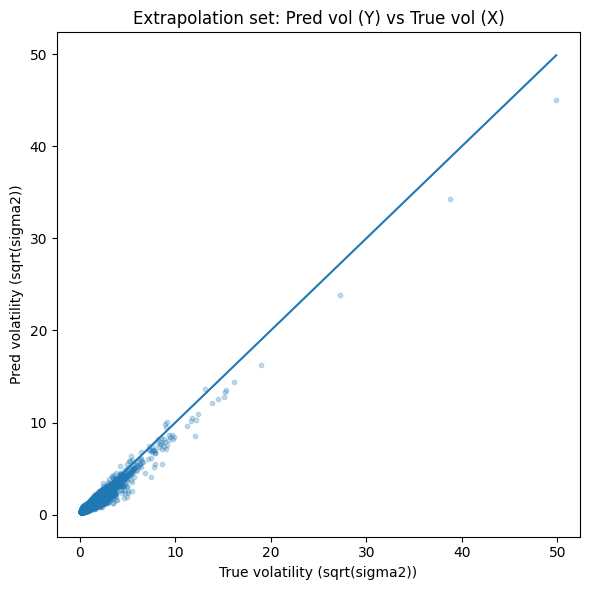

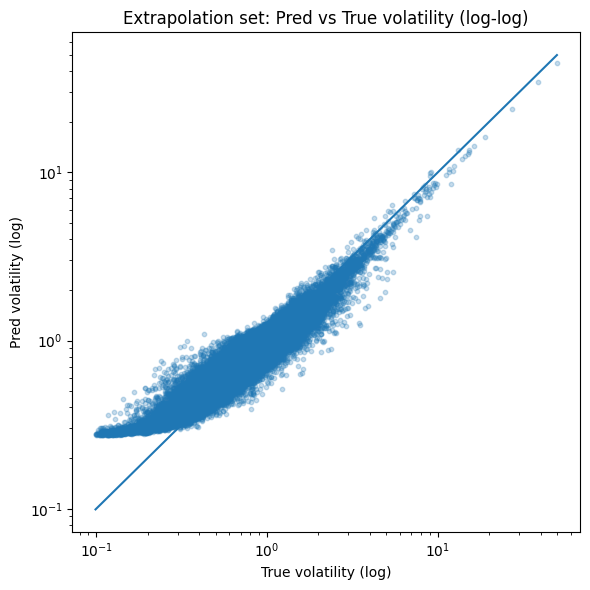

MSE(vol): 0.025936415
log-MSE(vol): 0.037309915
corr(log vol): 0.9528238695571589


In [47]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def collect_true_pred_sigma2(model, loader, device, max_batches=None, eps=1e-12):
    model.eval()
    y_true_list, y_pred_list = [], []

    with torch.no_grad():
        for b, batch in enumerate(loader):
            if max_batches is not None and b >= max_batches:
                break

            xb = batch[0].to(device)
            yb = batch[1].to(device)

            out = model(xb)
            pred = out[0] if isinstance(out, (tuple, list)) else out

            pred = torch.clamp(pred, min=eps)
            yb   = torch.clamp(yb,   min=eps)

            y_true_list.append(yb.detach().cpu().numpy().reshape(-1))
            y_pred_list.append(pred.detach().cpu().numpy().reshape(-1))

    return np.concatenate(y_true_list), np.concatenate(y_pred_list)


# --- Extrapolation set ---
s2_true_ex, s2_pred_ex = collect_true_pred_sigma2(model_ood, ex_loader, device)

# --- Convert to volatility ---
vol_true = np.sqrt(s2_true_ex)
vol_pred = np.sqrt(s2_pred_ex)

print("Nb points:", len(vol_true))

# --- Scatter: X=true vol, Y=pred vol ---
plt.figure(figsize=(6,6))
plt.scatter(vol_true, vol_pred, s=10, alpha=0.25)

mn = float(min(vol_true.min(), vol_pred.min()))
mx = float(max(vol_true.max(), vol_pred.max()))
plt.plot([mn, mx], [mn, mx])  # y=x

plt.title("Extrapolation set: Pred vol (Y) vs True vol (X)")
plt.xlabel("True volatility (sqrt(sigma2))")
plt.ylabel("Pred volatility (sqrt(sigma2))")
plt.tight_layout()
plt.show()

# --- Version log-log (optionnelle mais utile si distribution très étalée) ---
plt.figure(figsize=(6,6))
plt.scatter(vol_true, vol_pred, s=10, alpha=0.25)
plt.plot([mn, mx], [mn, mx])
plt.xscale("log")
plt.yscale("log")
plt.title("Extrapolation set: Pred vs True volatility (log-log)")
plt.xlabel("True volatility (log)")
plt.ylabel("Pred volatility (log)")
plt.tight_layout()
plt.show()

# --- Metrics sur vol ---
mse_vol = np.mean((vol_pred - vol_true)**2)
log_mse_vol = np.mean((np.log(vol_pred) - np.log(vol_true))**2)
corr_log = np.corrcoef(np.log(vol_true), np.log(vol_pred))[0,1]

print("MSE(vol):", mse_vol)
print("log-MSE(vol):", log_mse_vol)
print("corr(log vol):", corr_log)


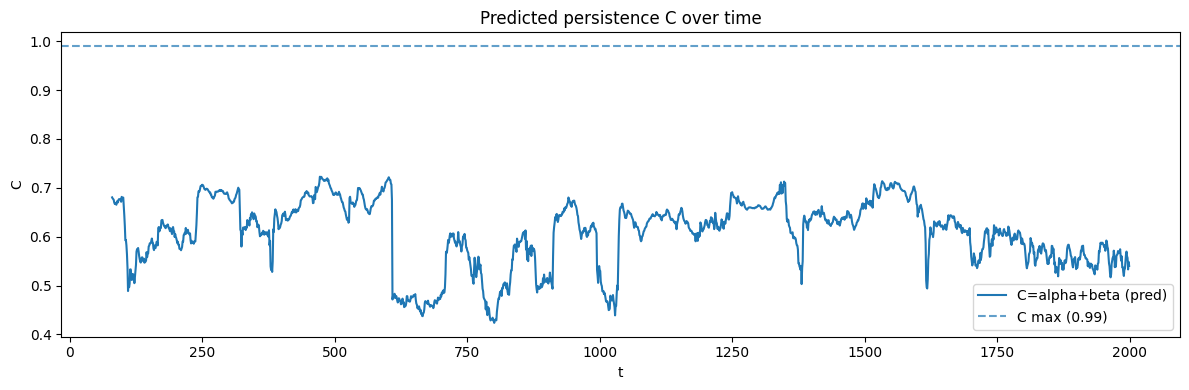

In [49]:


j = 0
r_series = ex_returns[j].cpu().numpy()
W = WINDOW_SIZE
omega_p, alpha_p, beta_p, C_p = omega_p, alpha_p, beta_p, C_p = rolling_params(model_ood, r_series, W, device)


t = np.arange(W, W+len(C_p))

plt.figure(figsize=(12,4))
plt.plot(t, C_p, label="C=alpha+beta (pred)")
plt.axhline(0.99, linestyle="--", alpha=0.7, label="C max (0.99)")
plt.title("Predicted persistence C over time")
plt.xlabel("t")
plt.ylabel("C")
plt.legend()
plt.tight_layout()
plt.show()


Test on real times series

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HIDDEN_DIM = 32  # doit matcher ton checkpoint
ckpt_path = "hybrid_garch_pretrained_synth_full.pt"

model_full = HybridGarch(hidden=HIDDEN_DIM).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model_full.load_state_dict(ckpt["model_state"] if "model_state" in ckpt else ckpt)
model_full.eval()


HybridGarch(
  (net): GarchParamNet(
    (conv): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (4): GroupNorm(8, 32, eps=1e-05, affine=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (7): GroupNorm(8, 32, eps=1e-05, affine=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      (10): GroupNorm(8, 32, eps=1e-05, affine=True)
      (11): LeakyReLU(negative_slope=0.2)
      (12): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
      (13): GroupNorm(8, 32, eps=1e-05, affine=True)
      (14): LeakyReLU(negative_slope=0.2)
    )
    (fc): Sequential(
      (0): Linear(in_feat

In [58]:
import yfinance as yf

def load_returns_yf(ticker, start="2015-01-01", end=None):
    df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    # auto_adjust=True => "Close" déjà ajusté
    px = df["Close"].dropna()
    r = np.log(px).diff().dropna()  # log-returns
    return r

tickers = [
    "AAPL",   # Apple (Tech / Consommation)
    "MSFT",   # Microsoft (Logiciels / Cloud)
    "SPY",    # S&P 500 ETF (Indice large US)
    "GOOGL",  # Alphabet (Recherche / IA)
    "AMZN",   # Amazon (E-commerce / Cloud)
    "TSLA",   # Tesla (Automobile / Énergie)
    "NVDA",   # NVIDIA (Semi-conducteurs / IA)
    "META",   # Meta (Réseaux sociaux)
    "BRK-B",  # Berkshire Hathaway (Holding de Warren Buffett)
    "V"       # Visa (Services financiers)
]
rets = {t: load_returns_yf(t, start="2012-01-01") for t in tickers}

for t in tickers:
    print(t, "n=", len(rets[t]))


AAPL n= 3541
MSFT n= 3541
SPY n= 3541
GOOGL n= 3541
AMZN n= 3541
TSLA n= 3541
NVDA n= 3541
META n= 3446
BRK-B n= 3541
V n= 3541


In [60]:

def nn_predict_sigma2_from_window(model, window_r, mean_train, std_train, device, eps=1e-12):
    """
    window_r: np.array shape (W,) en returns réels
    mean_train/std_train: stats train du ticker (réel)
    Retourne sigma2 prédite en unités réelles (pas normalisées)
    """
    # normalize like you did in synth
    w = (window_r - mean_train) / (std_train + 1e-8)
    xb = torch.tensor(w, dtype=torch.float32, device=device).unsqueeze(0)  # (1,W)

    out = model(xb)
    pred = out[0] if isinstance(out, (tuple, list)) else out  # (1,) ou (1,1)
    pred = torch.clamp(pred, min=eps).view(-1)[0].item()      # variance normalisée

    # de-normalize variance: sigma2_real = sigma2_norm * std^2
    return pred * (std_train + 1e-8)**2

def rolling_forecast_nn(model, r, W, train_ratio=0.7, device="cpu"):
    """
    r: pd.Series ou np.array de log-returns
    Renvoie pred_sigma2 pour la partie test + r_test
    """
    r = np.asarray(r)
    n = len(r)
    split = int(train_ratio * n)

    r_train = r[:split]
    mean_train = r_train.mean()
    std_train  = r_train.std(ddof=0)

    # forecasts for t in [split .. n-1]
    preds = []
    r2_real = []
    idxs = []

    for t in range(split, n):
        if t - W < 0:
            continue
        window = r[t-W:t]
        s2_hat = nn_predict_sigma2_from_window(model, window, mean_train, std_train, device)
        preds.append(s2_hat)
        r2_real.append(r[t]**2)     # proxy: next-day squared return
        idxs.append(t)

    return np.array(preds), np.array(r2_real), np.array(idxs)


In [61]:
from arch import arch_model

def rolling_forecast_arch(r, W, train_ratio=0.7, refit_every=5):
    r = np.asarray(r)
    n = len(r)
    split = int(train_ratio * n)

    preds = []
    r2_real = []
    idxs = []

    last_fit_t = None
    last_res = None

    for t in range(split, n):
        if t - W < 0:
            continue

        # refit périodique (plus rapide)
        if (last_fit_t is None) or ((t - last_fit_t) >= refit_every):
            window = r[t-W:t]
            am = arch_model(window * 100, mean="Zero", vol="GARCH", p=1, q=1, dist="normal")
            last_res = am.fit(disp="off")
            last_fit_t = t

        # forecast 1-step ahead
        f = last_res.forecast(horizon=1, reindex=False)
        # variance en (%^2) -> remettre en unités de r (log-return) :
        s2_hat = (f.variance.values[-1, 0]) / (100**2)

        preds.append(s2_hat)
        r2_real.append(r[t]**2)
        idxs.append(t)

    return np.array(preds), np.array(r2_real), np.array(idxs)


In [62]:
def qlike(r2, s2_hat, eps=1e-12):
    s2_hat = np.maximum(s2_hat, eps)
    return np.mean(r2 / s2_hat + np.log(s2_hat))

def log_mse_on_r2(r2, s2_hat, eps=1e-12):
    return np.mean((np.log(np.maximum(r2, eps)) - np.log(np.maximum(s2_hat, eps)))**2)


In [63]:
results = []

W = WINDOW_SIZE
for tkr in tickers:
    r = rets[tkr].values

    nn_s2, nn_r2, nn_idx = rolling_forecast_nn(model_full, r, W=W, train_ratio=0.7, device=device)
    ar_s2, ar_r2, ar_idx = rolling_forecast_arch(r, W=W, train_ratio=0.7, refit_every=5)

    # aligner au cas où indices diffèrent
    m = min(len(nn_s2), len(ar_s2))
    nn_s2, nn_r2 = nn_s2[-m:], nn_r2[-m:]
    ar_s2, ar_r2 = ar_s2[-m:], ar_r2[-m:]

    results.append({
        "ticker": tkr,
        "NN_QLIKE": qlike(nn_r2, nn_s2),
        "ARCH_QLIKE": qlike(ar_r2, ar_s2),
        "NN_logMSE_r2": log_mse_on_r2(nn_r2, nn_s2),
        "ARCH_logMSE_r2": log_mse_on_r2(ar_r2, ar_s2),
        "n_test_points": m
    })

df_res = pd.DataFrame(results).sort_values("ARCH_QLIKE")
df_res


,ticker,NN_QLIKE,ARCH_QLIKE,NN_logMSE_r2,ARCH_logMSE_r2,n_test_points
8,BRK-B,-7.762433,-7.762691,7.159465,7.367754,1063
2,SPY,-7.525793,-7.474775,9.012680,9.153845,1063
9,V,-7.149709,-7.137089,7.587673,7.770039,1063
1,MSFT,-6.851191,-6.884096,8.114878,8.289822,1063
3,GOOGL,-6.601598,-6.681420,7.765773,8.054358,1063
0,AAPL,-6.714574,-6.679775,8.733958,8.952930,1063
4,AMZN,-6.180253,-6.228172,9.103105,9.490174,1063
7,META,-5.392555,-5.603016,8.761208,9.432825,1034
6,NVDA,-5.467120,-5.467900,7.980604,8.204085,1063
5,TSLA,-5.354583,-5.361631,8.376175,8.490337,1063


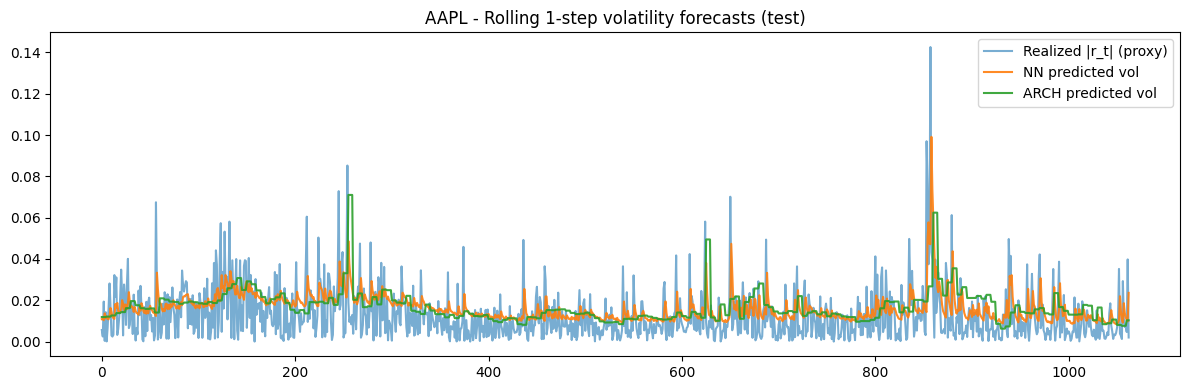

In [64]:
tkr = tickers[0]
r = rets[tkr].values

nn_s2, nn_r2, _ = rolling_forecast_nn(model_full, r, W=W, train_ratio=0.7, device=device)
ar_s2, ar_r2, _ = rolling_forecast_arch(r, W=W, train_ratio=0.7, refit_every=5)

m = min(len(nn_s2), len(ar_s2))
nn_s2, nn_r2 = nn_s2[-m:], nn_r2[-m:]
ar_s2, ar_r2 = ar_s2[-m:], ar_r2[-m:]

vol_nn = np.sqrt(nn_s2)
vol_ar = np.sqrt(ar_s2)
vol_real = np.sqrt(nn_r2)  # proxy: |r_t|

plt.figure(figsize=(12,4))
plt.plot(vol_real, label="Realized |r_t| (proxy)", alpha=0.6)
plt.plot(vol_nn, label="NN predicted vol", alpha=0.9)
plt.plot(vol_ar, label="ARCH predicted vol", alpha=0.9)
plt.title(f"{tkr} - Rolling 1-step volatility forecasts (test)")
plt.legend()
plt.tight_layout()
plt.show()


REAL DATA

In [68]:
# Liste de 100 tickers majeurs pour ton entraînement
sp500 = [
    # TECH & SEMIS
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "AVGO", "ADBE", "CRM", "INTC",
    "CSCO", "ORCL", "TSM", "AMD", "QCOM", "TXN", "AMAT", "MU", "LRCX", "ADI",
    # FINANCE
    "JPM", "V", "MA", "BAC", "MS", "GS", "WFC", "BLK", "AXP", "PYPL",
    "C", "SCHW", "CB", "MMC", "PGR", "MET", "AIG", "TRV", "TROW", "BEN",
    # SANTÉ
    "UNH", "JNJ", "LLY", "ABBV", "MRK", "PFE", "TMO", "DHR", "ABT", "AMGN",
    "ISRG", "GILD", "BMY", "VRTX", "CI", "HUM", "REGN", "BIIB", "BSX", "MDT",
    # CONSOMMATION & AUTO
    "TSLA", "WMT", "HD", "PG", "KO", "PEP", "COST", "NKE", "MCD", "SBUX",
    "TGT", "LOW", "TJX", "DG", "DLTR", "ORLY", "AZO", "GM", "F", "STLA",
    # ÉNERGIE & INDUSTRIE
    "XOM", "CVX", "COP", "SLB", "EOG", "PXD", "MPC", "VLO", "CAT", "DE",
    "GE", "HON", "UPS", "LMT", "BA", "MMM", "RTX", "NSC", "UNP", "ETN"
]

import yfinance as yf
import pandas as pd
import numpy as np

def get_clean_data(tickers, n_samples=1000):
    print(f"Téléchargement de {len(tickers)} tickers...")
    # On télécharge les prix de clôture
    data = yf.download(tickers, period="6y", interval="1d")['Close']

    # On garde les 1000 derniers jours et on nettoie
    df_prices = data.tail(n_samples).ffill().bfill()

    # Calcul des Log-Returns pour le modèle Hybrid GARCH
    # On utilise log-returns car ils sont additifs et plus proches d'une distribution normale
    df_returns = np.log(df_prices / df_prices.shift(1)).dropna()

    return df_returns

# Extraction des données
returns_df = get_clean_data(sp500)

# Préparation des segments [0:600], [600:700], [700:800]
# Note: On travaille sur les colonnes (tickers) en transposant pour le modèle
all_series = returns_df.values.T

train_set = all_series[:, 0:600]
val_set   = all_series[:, 600:700]
test_set  = all_series[:, 700:800]

print(f"Shape finale pour l'entraînement : {train_set.shape}")

/tmp/ipython-input-1653355626.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="6y", interval="1d")['Close']
[*                      2%                       ]  2 of 100 completed

Téléchargement de 100 tickers...


[*********************100%***********************]  100 of 100 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFPricesMissingError('possibly delisted; no price data found  (period=6y) (Yahoo error = "No data found, symbol may be delisted")')


Shape finale pour l'entraînement : (100, 0)


In [71]:
# Calcul des stats sur le train uniquement
train_mean = train_set.mean(axis=1, keepdims=True)
train_std = train_set.std(axis=1, keepdims=True)

# Application à tous les sets
train_norm = (train_set - train_mean) / train_std
val_norm = (val_set - train_mean) / train_std
test_norm = (test_set - train_mean) / train_std

/tmp/ipython-input-1095080511.py:2: RuntimeWarning: Mean of empty slice.
  train_mean = train_set.mean(axis=1, keepdims=True)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:207: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [78]:
# 1. On crée le modèle comme avant
model = HybridGarch()

# 2. On charge le fichier complet
checkpoint = torch.load('hybrid_garch_pretrained_synth_full.pt')

# 3. On extrait UNIQUEMENT les poids (le 'model_state') dans le modèle
model.load_state_dict(checkpoint['model_state'])

model.train()
print("✅ Modèle chargé avec succès en utilisant la clé 'model_state' !")

# Optionnel : tu peux voir tes anciens réglages si tu veux
print(f"Ancienne window_size : {checkpoint.get('window_size')}")

✅ Modèle chargé avec succès en utilisant la clé 'model_state' !
Ancienne window_size : 90


In [1]:
# ============================================================================
# TRANSFER LEARNING: Fine-tune on 100 Yahoo Finance Time Series
# ============================================================================

# 1. Charger ton modèle pré-entraîné
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridGarch(hidden=32).to(device)
model.load_state_dict(torch.load('sample_data/hybrid_garch_pretrained_synth_full.pt', map_location=device))
print("✓ Modèle pré-entraîné chargé")

# 2. Les données yfinance sont déjà téléchargées dans ton notebook
# Je suppose que tu as déjà : sp500_returns (100 tickers x T timesteps)
# Si pas encore, utilise ce code:
"""
import yfinance as yf

sp500 = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "AVGO", "ADBE", "CRM", "INTC",
    "CSCO", "ORCL", "TSM", "AMD", "QCOM", "TXN", "AMAT", "MU", "LRCX", "ADI",
    "JPM", "V", "MA", "BAC", "MS", "GS", "WFC", "BLK", "AXP", "PYPL",
    "C", "SCHW", "CB", "MMC", "PGR", "MET", "AIG", "TRV", "TROW", "BEN",
    "UNH", "JNJ", "LLY", "ABBV", "MRK", "PFE", "TMO", "DHR", "ABT", "AMGN",
    "ISRG", "GILD", "BMY", "VRTX", "CI", "HUM", "REGN", "BIIB", "BSX", "MDT",
    "TSLA", "WMT", "HD", "PG", "KO", "PEP", "COST", "NKE", "MCD", "SBUX",
    "TGT", "LOW", "TJX", "DG", "DLTR", "ORLY", "AZO", "GM", "F", "STLA",
    "XOM", "CVX", "COP", "SLB", "EOG", "PXD", "MPC", "VLO", "CAT", "DE",
    "GE", "HON", "UPS", "LMT", "BA", "MMM", "RTX", "NSC", "UNP", "ETN"
]

data = yf.download(sp500, period="6y", interval="1d")['Close']
df_prices = data.tail(1000).ffill().bfill()
df_returns = np.log(df_prices / df_prices.shift(1)).dropna()
sp500_returns = torch.tensor(df_returns.values.T, dtype=torch.float32)  # (100, 999)

# Standardiser chaque série
sp500_returns = (sp500_returns - sp500_returns.mean(dim=1, keepdim=True)) / (sp500_returns.std(dim=1, keepdim=True) + 1e-8)
"""

# 3. Split train[0:600], val[600:700], test[700:800]
train_returns = sp500_returns[:, :600]
val_returns = sp500_returns[:, 600:700]
test_returns = sp500_returns[:, 700:800]

print(f"Train: {train_returns.shape}, Val: {val_returns.shape}, Test: {test_returns.shape}")

# 4. Fit GARCH(1,1) sur chaque série pour obtenir les vraies variances (targets)
from arch import arch_model

def fit_garch_variances(returns_mat):
    """Fit GARCH(1,1) sur chaque série pour obtenir les variances conditionnelles"""
    n_series, T = returns_mat.shape
    variances = torch.zeros_like(returns_mat)

    for i in range(n_series):
        try:
            r = returns_mat[i].numpy() * 100  # Scale pour stabilité numérique
            model_garch = arch_model(r, vol='Garch', p=1, q=1, rescale=False)
            res = model_garch.fit(disp='off', show_warning=False)
            variances[i] = torch.tensor((res.conditional_volatility / 100) ** 2, dtype=torch.float32)
        except:
            # Fallback: rolling variance
            variances[i] = torch.tensor(
                pd.Series(returns_mat[i].numpy() ** 2).rolling(20).var().fillna(method='bfill').values,
                dtype=torch.float32
            )

    return variances

print("Fitting GARCH(1,1) pour obtenir les vraies variances...")
train_variances = fit_garch_variances(train_returns)
val_variances = fit_garch_variances(val_returns)
test_variances = fit_garch_variances(test_returns)
print("✓ Variances calculées")

# 5. Créer les datasets avec ta classe MultiGARCHDataset
W = 30  # Window size (doit matcher le modèle)
stride = 10

train_dataset = MultiGARCHDataset(train_returns, train_variances, window_size=W, stride=stride)
val_dataset = MultiGARCHDataset(val_returns, val_variances, window_size=W, stride=stride)
test_dataset = MultiGARCHDataset(test_returns, test_variances, window_size=W, stride=stride)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Samples: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# 6. Fine-tuning avec ta fonction train_hybrid_garch
# Learning rate RÉDUIT pour ne pas détruire les poids pré-entraînés
lr_finetune = 1e-4  # Plus petit que le lr initial (probablement 1e-3 ou 5e-4)
n_epochs = 30

print("\nDébut du fine-tuning...")
history = train_hybrid_garch(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    lr=lr_finetune,
    device=device,
    ckpt_path="hybrid_garch_finetuned_yfinance.pt"
)

# 7. Évaluation sur test set avec ta fonction eval_log_mse
test_loss = eval_log_mse(model, test_loader, device)
print(f"\n✓ Fine-tuning terminé!")
print(f"Test log-MSE: {test_loss:.6f}")

# 8. Plot des courbes de loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.axhline(test_loss, color='red', linestyle='--', label=f'Test Loss = {test_loss:.6f}')
plt.xlabel('Epoch')
plt.ylabel('Loss (log-variance MSE)')
plt.title('Fine-Tuning: Hybrid GARCH-NN sur 100 séries Yahoo Finance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Modèle fine-tuné sauvegardé : hybrid_garch_finetuned_yfinance.pt")

NameError: name 'torch' is not defined